In [7]:
%pip install qdrant-client

Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from adic_components.prototype2 import P2GPTBlock
from adic_components.prototype3 import P3ECDEC, P3Decoder
from adic_components.DyT import DyT
from adic_components.CaptionsDataset import add_bos_eos
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
gpt2_model_pretrained = GPT2Model.from_pretrained('gpt2')
# Get model config to know vocab size and hidden size
config = GPT2Config.from_pretrained('gpt2')
vocab_size = config.vocab_size
hidden_size = config.n_embd
gpt2 = P2GPTBlock(config)
gpt2.load_state_dict(gpt2_model_pretrained.state_dict(), strict=False)
decoder = P3Decoder(config)
decoder.gpt2 = gpt2
encodeco = P3ECDEC(3, 224, 224, hidden_size, decoder)
LOCAL_WEIGHTS_PATH = 'prototype3_release13.pth'
model = encodeco.to(device)
#freze the decoder
# how about no for once
for name, param in model.decoder.gpt2.named_parameters():
    param.requires_grad = False

In [10]:
model.load_state_dict(torch.load(LOCAL_WEIGHTS_PATH, map_location=torch.device(device)))
model = model.to(device)

In [23]:
data = [
    {"text": "black chair", "url": "https://images.pexels.com/photos/2762247/pexels-photo-2762247.jpeg?_gl=1*1u0l87r*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MDQ4NTQkbzMkZzEkdDE3NTE4MDUwODQkajQ1JGwwJGgw"},
    {"text": "chair on a bridge", "url": "https://images.pexels.com/photos/32784050/pexels-photo-32784050.jpeg?_gl=1*1ocw8nu*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MDQ4NTQkbzMkZzEkdDE3NTE4MDUwMzMkajIzJGwwJGgw"},
    {"text": "cat on pillow", "url": "https://images.pexels.com/photos/29328551/pexels-photo-29328551.jpeg?_gl=1*xa5qz*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MDQ4NTQkbzMkZzEkdDE3NTE4MDQ5NzEkajI0JGwwJGgw"},
    {"text": "cat on chair", "url": "https://images.pexels.com/photos/26734107/pexels-photo-26734107.jpeg?_gl=1*1ae89cc*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MDQ4NTQkbzMkZzEkdDE3NTE4MDQ5MzYkajU5JGwwJGgw"},
    {"text": "cat on ground", "url": "https://images.pexels.com/photos/32706805/pexels-photo-32706805.jpeg?_gl=1*1diplkm*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MDQ4NTQkbzMkZzEkdDE3NTE4MDQ4OTEkajIzJGwwJGgw"},
    {"text": "pelican swimming in water", "url": "https://images.pexels.com/photos/32703696/pexels-photo-32703696.jpeg?_gl=1*u0ropu*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjI5MzkkajUyJGwwJGgw"},
    {"text": "pelican on ground", "url": "https://images.pexels.com/photos/21303425/pexels-photo-21303425.jpeg?_gl=1*1frs2wx*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjI5ODckajQkbDAkaDA."},
    {"text": "pelican on log", "url": "https://images.pexels.com/photos/26699370/pexels-photo-26699370.jpeg?_gl=1*aj2svt*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjMwNTkkajU5JGwwJGgw"},
    {"text": "old temple", "url": "https://images.pexels.com/photos/32751828/pexels-photo-32751828.jpeg?_gl=1*1lfy57d*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjMxMjckajU4JGwwJGgw"},
    {"text": "very decorated temple", "url": "https://images.pexels.com/photos/22585864/pexels-photo-22585864.jpeg?_gl=1*1u5yo10*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjMxNzkkajYkbDAkaDA."}


]

In [24]:
from qdrant_client import QdrantClient, models

client = QdrantClient("localhost", prefer_grpc=True)

client.recreate_collection(
    collection_name="image_embeddings",
    vectors_config= models.VectorParams(
        size=model.decoder.hidden_size,
        distance=models.Distance.MANHATTAN,
    )
)

/tmp/ipykernel_548075/1057549379.py:5: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [25]:
import requests
from PIL import Image
from io import BytesIO
from adic_components.CaptionsDataset import augmentation_test_transform
import uuid


for item in data:
    response = requests.get(item["url"])
    img = Image.open(BytesIO(response.content))
    pixels = augmentation_test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model.encoder(pixels).squeeze(0).sum(dim=0) / pixels.shape[0]
        embedding = embedding.cpu().numpy()
        client.upsert(
            collection_name="image_embeddings",
            points= [
                models.PointStruct(
                    id= str(uuid.uuid4()),
                    vector=embedding,
                    payload={"text": item["text"], "url": item["url"]}
                )
            ]
        )

['<|endoftext|>A bird is sitting on a wire.<|endoftext|>']


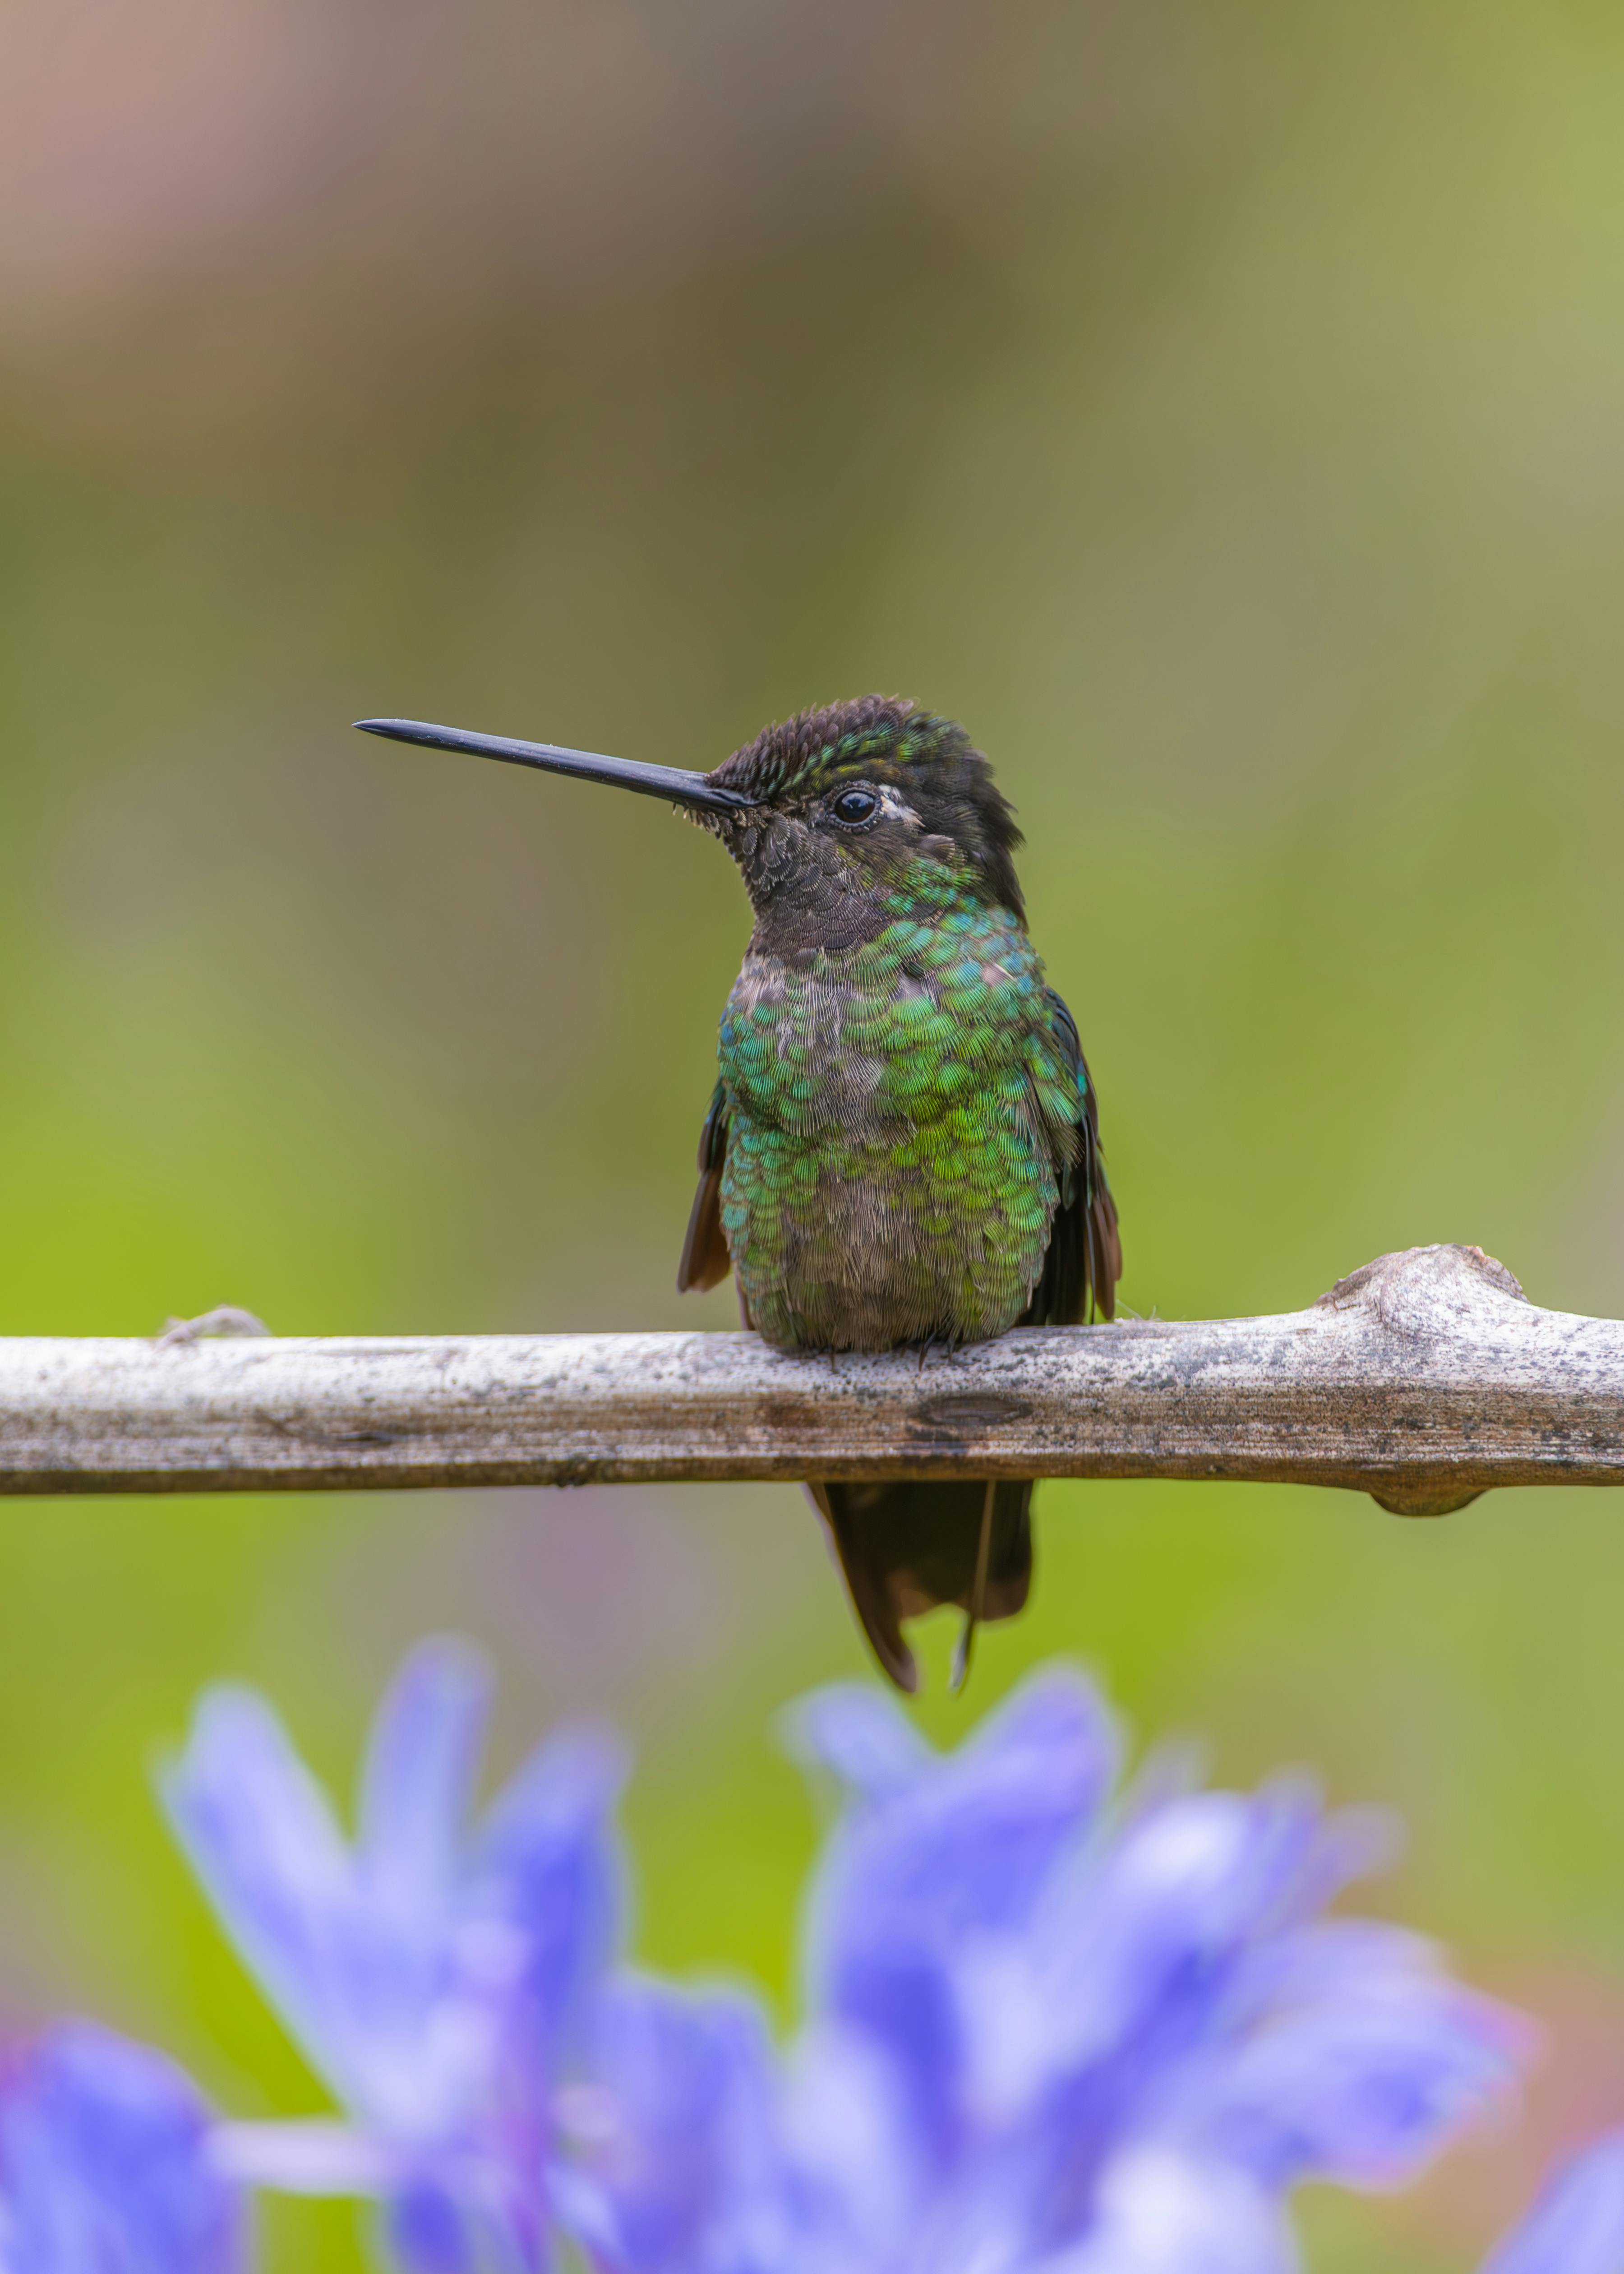

In [28]:
from PIL import Image
import requests
from io import BytesIO
from adic_components.CaptionsDataset import augmentation_test_transform
url = '''


https://images.pexels.com/photos/32102378/pexels-photo-32102378.jpeg?_gl=1*12qyduy*_ga*MjEyNjc5OTI4NC4xNzUwMTkxNjEy*_ga_8JE65Q40S6*czE3NTE4MjI5MzEkbzUkZzEkdDE3NTE4MjM4OTYkajU1JGwwJGgw
'''
model.eval()
response = requests.get(url)
img = Image.open(BytesIO(response.content))
org = img.copy()
with torch.no_grad():
  img_pixel_values = augmentation_test_transform(img).unsqueeze(0)
  img_pixel_values = img_pixel_values.to(device)
  decoder_output = model.generate(img_pixel_values, max_length=16)
  generated = tokenizer.batch_decode(decoder_output.cpu().tolist())
print(generated)
org